In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.integrate import simpson

In [2]:
common_settings = {
'perturbations_verbose':0,
'background_verbose':0,
'output':'mPk',
'gauge':'newtonian',
'P_k_max_1/Mpc':300,
'z_max_pk':1000,
'format':'class'
}

chiCDM = Class()
# pass input parameters
chiCDM.set(common_settings)
chiCDM.set({
'omega_cdm':0.10,
'f_chi':1.e-10 ,
'acs_chi':1.e-7,
'cs2_peak_chi':1./3.,
})

chiCDM.compute()

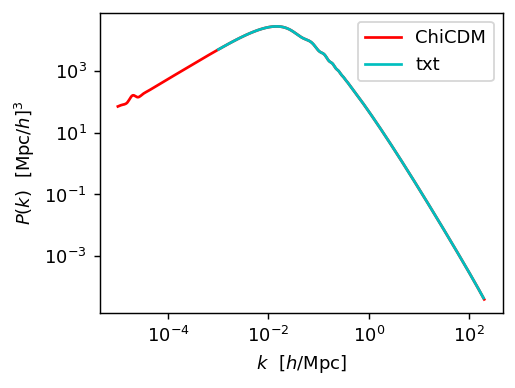

In [3]:
from scipy.interpolate import interp1d
fact=(2*np.pi)**3

kk = np.logspace(-5,np.log10(200),500) # k in h/Mpc
Pkchi = [] # P(k) in (Mpc/h)**3
h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc

lowz=0.

for k in kk:
    Pkchi.append(chiCDM.pk_lin(k*h,lowz)*h**3) # function .pk(k,z)
Pkchi=np.array(Pkchi)

Pchi_int = interp1d(kk, Pkchi, fill_value='extrapolate')


plt.figure(figsize=(4,3), dpi=130)
plt.xscale('log');plt.yscale('log');
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')


plt.plot(kk,Pkchi,'r-',label=r'ChiCDM')

plt.plot(kk[:-1]+1.e-3,Pchi_int(kk[:-1]+1.e-3),'c-',label=r'txt')


plt.legend()
plt.show()

----
1-loop computation

In [7]:
# a la https://arxiv.org/pdf/1106.2607
klist=np.logspace(-2,0,100)
# klist=[0.1]
onelterm=[]
eps=1.e-4
for k in klist:
    # print('k='+str(k))
    k2=k*k
    pp1 = np.linspace(eps,k-eps,101)
    pp2 = np.linspace(k+eps,10,101)
    pp = np.concatenate((pp1,pp2))
    intgndp = np.zeros_like(pp)
    for i in range(len(pp)):
        p = pp[i]
        p2=p*p
        low=np.abs(p-k/2.)+k/2.
        q= np.logspace(np.log10(low), np.log10(k+p), 201) #occhio questo e un vettore eh
        q2= q*q
        intgndq = (2*k2*k2+3*k2*(q2+p2)+10*p2*q2-5*(p2*p2+q2*q2))**2
        intgndq /= (14**2)*p2*p*q2*q
        intgndq *= Pchi_int(q)
        qintegral = simpson(intgndq,q)
        #P13 piece
        piece13 = k2*k/252*(12*k2/p2-158+100*p2/k2-42*p2*p2/k2/k2-3*k2*k/p2/p*(7*p2/k2+2)*((p2/k2-1)**3)*np.log(np.abs(1-p/k)/(1+p/k)))
        piece13*=Pchi_int(k)

        intgndp[i]=2*np.pi/k*(qintegral+piece13)*Pchi_int(p)
    pintegral = simpson(intgndp,pp)/fact
    onelterm.append(pintegral)
onelterm=np.array(onelterm)

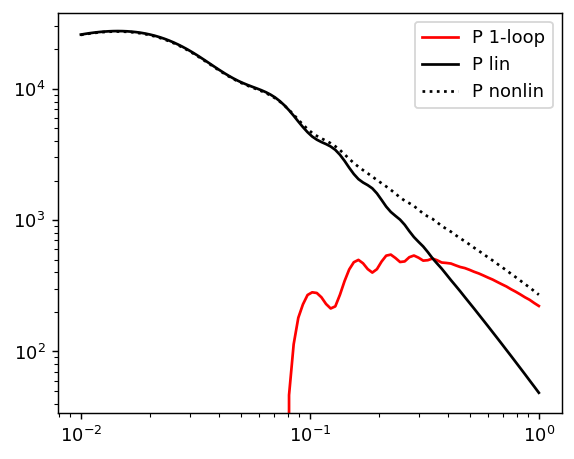

In [9]:
plt.figure(figsize=(5,4), dpi=130)

plt.plot(klist,onelterm, 'r',label=r'P 1-loop')
qq = np.logspace(-2,0,100) 

plt.plot(qq,Pchi_int(qq),'k',label=r'P lin')
plt.plot(klist,Pchi_int(klist)+onelterm,'k:',label=r'P nonlin')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()